# Simulations

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

from IPython.display import clear_output
import os.path


## Algorithms

In [2]:
def compute_flight_metric(data, 
                            selected_rows = None,
                            flight = 'flight',
                            muid = 'RAWMUID',
                            seg = 'Segment',
                            metric = 'metric',
                            metric_type = 'single average'):
    ''' 
    compute metric aggregrate for each flight
    
    Args:
        data          - the pandas dataframe [RAWMUID, Segment, flight, metric]    
        selected_rows - a series that shows what rows are selected.
        flight        - flight column name
        muid          - muid column name
        seg           - segment column name
        metric        - metric column name
        metric_type   - string, sum, single average, double average, or proportion
    Returns:
        out           - dataframe [flight, metric_name]
    '''
    if flight not in data.columns or \
        muid not in data.columns or \
        seg not in data.columns or \
        metric not in data.columns:
        raise ValueError('flight/muid/seg/metric is not found in data.columns')
    if selected_rows is not None:
        filtered = data[selected_rows]
    else:
        filtered = data
    if metric_type == 'sum':
        prepare = filtered.groupby([muid, flight])[metric].sum().reset_index()
        out = prepare.groupby(flight)[metric].mean().to_frame('metric sum').reset_index()
    elif metric_type == 'single average':
        k = len(np.unique(filtered[seg]))
        prepare = (filtered.groupby([muid, flight])[metric].sum() / k).reset_index()
        out = prepare.groupby(flight)[metric].mean().to_frame('metric single average').reset_index()
    elif metric_type == 'double average':
        prepare = filtered.groupby([muid, flight])[metric].mean().reset_index()
        out = prepare.groupby(flight)[metric].mean().to_frame('metric double average').reset_index()
    elif metric_type == 'proportion':
        prepare = ((filtered.groupby([muid, flight])[metric].mean() > 0) * 1).reset_index()
        out = prepare.groupby(flight)[metric].mean().to_frame('metric proportion').reset_index()
    else:
        raise ValueError('metric type (%s) not allowed.'%metric_type)
    return out

In [3]:
def naive_continuous_analysis(data, 
                              treat_flight,
                              control_flight,
                              metric_type = 'single average',
                              difference = 'delta'):
    '''
    Compute the naive continuous analysis
    Args:
        data   - dataframe
        treat_flight - string, treat flight name
        control_flight - string, control flight name
        metric_type - string, the metric type
        difference  - string, delta or delta percentage
    Returns:
        result - a number
    '''

    if treat_flight not in np.unique(data['flight']) or \
        control_flight not in np.unique(data['flight']):
        raise ValueError('treat_flight/cotrol_flight not in data[flight]')
    #print((data['flight'] == 'treat_flight'))
    out = compute_flight_metric(data, 
                                (data['flight'] == treat_flight) | (data['flight'] == control_flight), 
                                metric_type = metric_type)
    treated = float(out.loc[out['flight'] == treat_flight, 'metric ' + metric_type])
    control = float(out.loc[out['flight'] == control_flight, 'metric ' + metric_type])
    if difference == 'delta':
        return treated - control
    elif difference == 'delta percentage':
        return treated / control - 1
def jackknife_continuous_analysis(data, 
                                block_len,
                                treat_flight,
                                control_flight,
                                metric_type = 'single average',
                                difference = 'delta'):
    '''
    Compute the jackknife continuous analysis
    Args:
        data   - dataframe
        block_len - int, length of the block
        treat_flight - string, treat flight name
        control_flight - string, control flight name
        metric_type - string, the metric type
        difference  - string, delta or delta percentage
    Returns:
        result - a number
    '''
    filtered = data[(data['flight'] == treat_flight) | (data['flight'] == control_flight)]
    naive = naive_continuous_analysis(filtered, 
                                      treat_flight = treat_flight, 
                                      control_flight = control_flight, 
                                      metric_type=metric_type, 
                                      difference=difference)
    jackknifed = []
    for i in range(min(data['Segment']), max(data['Segment']) - block_len + 2):
        out = compute_flight_metric(filtered, 
                                    (filtered['Segment'] < i) | (filtered['Segment'] >= i + block_len),
                                    metric_type = metric_type)
        treated = float(out.loc[out['flight'] == treat_flight, 'metric ' + metric_type])
        control = float(out.loc[out['flight'] == control_flight, 'metric ' + metric_type])
        if difference == 'delta':
            jackknifed.append(treated - control)
        elif difference == 'delta percentage':
            jackknifed.append(treated / control - 1)
        else:
            raise ValueError('difference (%s) is not allowed.'%difference)
    if (max(data['Segment']) + 1 - min(data['Segment']))%block_len != 0:
        raise ValueError('block_len (%d) should divide the range of the experiment (%d, %d).'%(block_len, max(data['Segment']), min(data['Segment'])))
    stepsize = (max(data['Segment']) + 1 - min(data['Segment']))/block_len - 1
    return (naive - (np.mean(jackknifed) - naive) * stepsize)

def block_bootstrap_continuous_analysis(data, 
                                        treat_flight,
                                        control_flight,
                                        block = 1,
                                        metric_type = 'single average',
                                        difference = 'delta',
                                        repeat = 10):
    '''
    Compute the jackknife continuous analysis
    Args:
        data   - dataframe
        block_len - int, length of the block
        treat_flight - string, treat flight name
        control_flight - string, control flight name
        block - number, size of a block
        metric_type - string, the metric type
        difference  - string, delta or delta percentage
        repeat - string, number of bootstrap samples
    Returns:
        result - a number
    '''
    days = np.arange(min(data['Segment']), max(data['Segment'])+1)
    naive = naive_continuous_analysis(data, 
                                      treat_flight = treat_flight, 
                                      control_flight = control_flight, 
                                      metric_type=metric_type, 
                                      difference=difference)
    tmp = []
    for _ in range(repeat):
        heads = sorted(np.array([x + np.arange(block) for x in np.random.choice(days[0:(len(days) - block + 1)], len(days)//block)]).flatten())
        bootstrapping_day = pd.DataFrame({'Segment':heads, 'NewSeg':np.arange(len(heads))})
        bootstrapping_data = pd.merge(bootstrapping_day, data, on='Segment')
        bootstrapping_data['Segment'] = bootstrapping_data['NewSeg']
        tmp.append(naive_continuous_analysis(bootstrapping_data, 
                                             treat_flight = treat_flight, 
                                             control_flight = control_flight, 
                                             metric_type=metric_type,
                                             difference=difference))
    return (naive * 2 - np.mean(tmp))

def block_bootstrap_fixed_analysis(data, 
                                   admission,
                                   observation,
                                   treat_flight,
                                   control_flight,
                                   block = 1,
                                   metric_type = 'single average',
                                   difference = 'delta',
                                   repeat = 10):
    '''
    Compute the bootstrap continuous analysis
    Args:
        data   - dataframe
        admission - int, admission period
        observation - int, observation period
        block - int, length of the block
        treat_flight - string, treat flight name
        control_flight - string, control flight name
        block - number, size of a block
        metric_type - string, the metric type
        difference  - string, delta or delta percentage
        repeat - string, number of bootstrap samples
    Returns:
        result - a number
    '''
    days = np.arange(min(data['Segment']), max(data['Segment'])+1)
    naive = naive_fixed_duration_analysis(data, 
                                          observation = observation,
                                          admission = admission,
                                          treat_flight = treat_flight, 
                                          control_flight = control_flight, 
                                          metric_type=metric_type, 
                                          difference=difference)
    tmp = []
    for _ in range(repeat):
        heads = sorted(np.array([x + np.arange(block) for x in np.random.choice(days[0:(len(days) - block + 1)], len(days)//block)]).flatten())
        bootstrapping_day = pd.DataFrame({'Segment':heads, 'NewSeg':np.arange(len(heads))})
        bootstrapping_data = pd.merge(bootstrapping_day, data, on='Segment')
        bootstrapping_data['Segment'] = bootstrapping_data['NewSeg']
        tmp.append(naive_fixed_duration_analysis(bootstrapping_data, 
                                                 admission = admission,
                                                 observation = observation,
                                                 treat_flight = treat_flight, 
                                                 control_flight = control_flight, 
                                                 metric_type=metric_type, 
                                                 difference=difference))
    return (naive * 2 - np.mean(tmp))

## Simulation Definition

### Data Simulation 1

In [4]:
def sim_user_outcome_1(num_days, freq_dist, treat_name, control_name, num_people):
    ''' Simualte a user outcome
    '''
    raw = []
    # generate treatment
    for i in range(num_people):
        pi = np.random.choice(freq_dist)
        for j in range(num_days):
            if np.random.rand() < pi:
                raw.append([j, i, treat_name, 1 + pi * 1 + np.random.normal(scale=.01)])
    # generate control
    for i in range(num_people, 2 * num_people):
        pi = np.random.choice(freq_dist)
        for j in range(num_days):
            if np.random.rand() < pi:
                raw.append([j, i, control_name, 1 + np.random.normal(scale=.01)])
    data = pd.DataFrame(columns=['Segment', 'RAWMUID', 'flight', 'metric'], data=raw)
    return(data)

### Data Simulation 2

In [5]:
def sim_user_outcome_2(num_days, freq_dist, treat_name, control_name, num_people):
    ''' Simualte a user outcome
    '''
    raw = []
    # generate treatment
    for i in range(num_people):
        pi = np.random.choice(freq_dist)
        used_days = 0
        for j in range(num_days):
            if np.random.rand() < pi:
                used_days += 1
                raw.append([j, i, treat_name, 1 + pi * (1 + 1/(10 * used_days)) + np.random.normal(scale=.01)])
    # generate control
    for i in range(num_people, 2 * num_people):
        pi = np.random.choice(freq_dist)
        for j in range(num_days):
            if np.random.rand() < pi:
                raw.append([j, i, control_name, 1 + np.random.normal(scale=.01)])
    data = pd.DataFrame(columns=['Segment', 'RAWMUID', 'flight', 'metric'], data=raw)
    return(data)

### Simulation Function: sim=1 for user outcome 1, sim=2 for user outcome 2

In [6]:
def simulate(sim=1, random_seed=42, num_sim=100, k=14, truth=1/3, dist_size = 1000, difference='delta', metric_type='single average'):
    # set global np random seed
    np.random.seed(random_seed)
    
    naive = []
    jackknife_est = []
    bootstrap = []
    for trial in range(num_sim):
        if sim == 1:
            data = sim_user_outcome_1(k, np.random.uniform(size = (dist_size,)), 'T', 'C', dist_size)
        elif sim==2:
            data = sim_user_outcome_2(k, np.random.uniform(size = (dist_size,)), 'T', 'C', dist_size)
        # experiment naive
        naive.append(naive_continuous_analysis(data, 'T', 'C', difference=difference, metric_type=metric_type) - truth)
        # jackknifed
        jackknife_est.append(jackknife_continuous_analysis(data, 
                                              block_len=1, 
                                              treat_flight='T', 
                                              control_flight='C', 
                                              metric_type=metric_type,
                                              difference=difference) - truth)
        # bootstrap
        bootstrap.append(block_bootstrap_continuous_analysis(data, 'T', 'C', difference=difference, metric_type=metric_type) - truth)
    
        
    plt.boxplot([naive, jackknife_est, bootstrap], labels=['original', 'jackknife', 'bootstrap'])
    print('continuous analysis : %.4f(%.4f)'%(np.mean(naive), np.std(naive)/len(naive)**.5)) # continuous analysis mean
    print('jackknife analysis : %.4f(%.4f)'%(np.mean(jackknife_est), np.std(jackknife_est)/len(jackknife_est)**.5)) # jackknife mean
    print('bootstrap analysis : %.4f(%.4f)'%(np.mean(bootstrap), np.std(bootstrap)/len(bootstrap) ** .5))
    print('paired t-test of naive and jackknifed estimate: statistic %.4f, p-value %f' %(stats.ttest_rel(naive, jackknife_est)))
    print('paired t-test of bootstrapped and jackknifed estimate: statistic %.4f, p-value %f' %(stats.ttest_rel(bootstrap, jackknife_est)))
    return np.mean(naive), np.mean(jackknife_est), np.mean(bootstrap), stats.ttest_rel(naive, jackknife_est), stats.ttest_rel(bootstrap, jackknife_est)

## Simulation 1

continuous analysis : -0.1456(0.0021)
jackknife analysis : -0.1696(0.0025)
bootstrap analysis : -0.1599(0.0023)
paired t-test of naive and jackknifed estimate: statistic 28.7539, p-value 0.000000
paired t-test of bootstrapped and jackknifed estimate: statistic 15.5189, p-value 0.000000


(-0.1455763533224955,
 -0.1695966676595202,
 -0.15989830128173277,
 Ttest_relResult(statistic=28.753901203489082, pvalue=7.391264092122291e-50),
 Ttest_relResult(statistic=15.518896623609233, pvalue=2.898327213690072e-28))

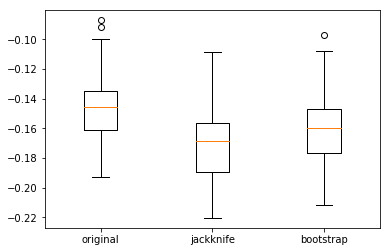

In [7]:
simulate(sim=1, truth=1/2)

## Simulation 2

continuous analysis : -0.1351(0.0021)
jackknife analysis : -0.1598(0.0025)
bootstrap analysis : -0.1497(0.0023)
paired t-test of naive and jackknifed estimate: statistic 29.3407, p-value 0.000000
paired t-test of bootstrapped and jackknifed estimate: statistic 16.0230, p-value 0.000000


(-0.13507414972946266,
 -0.1597996224042977,
 -0.1497076246265724,
 Ttest_relResult(statistic=29.34074269887496, pvalue=1.2313786568702372e-50),
 Ttest_relResult(statistic=16.023030171794296, pvalue=2.986949056459545e-29))

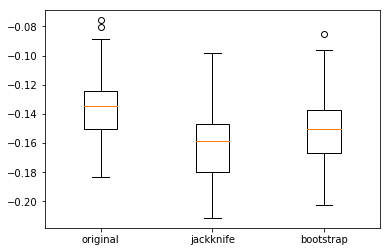

In [8]:
simulate(sim=2, truth=1/2)

## Simulate different seed, distribution size and k combinations

In [9]:
def sim_combinations():
    seed_list = [1, 42, 420]
    dist_list = [500, 1000, 2000]
    k_list = [7, 14, 28, 56]
    sim_list = [1, 2]
    replication_list = [10, 50, 100, 200]

    holder = []
    max_iter = len(seed_list) * len(dist_list) * len(k_list) * len(
        sim_list) * len(replication_list)
    counter = 0
    for seed in seed_list:
        for dist_size in dist_list:
            for k in k_list:
                for sim in sim_list:
                    for replication in replication_list:
                        counter += 1
                        sim_res = simulate(sim=sim,
                                           random_seed=seed,
                                           dist_size=dist_size,
                                           k=k,
                                           num_sim=replication)
                        sim_entry = {
                            'sim': sim,
                            'seed': seed,
                            'dist_size': dist_size,
                            'k': k,
                            'n_rep': replication,
                            'naive_mean': sim_res[0],
                            'jackknife_mean': sim_res[1],
                            'bootstrap_mean': sim_res[2],
                            'naive_t_test': sim_res[3],
                            'bootstrap_t_test': sim_res[4]
                        }
                        holder.append(sim_entry)
                        clear_output(wait=True)
                        print('{}/{} simulations completed.'.format(
                            counter, max_iter))
    return holder

In [10]:
SIM_PATH = 'combination_results.csv'
if os.path.isfile(SIM_PATH):
    combination_results = pd.read_csv(SIM_PATH)
else:
    combination_results = pd.DataFrame(sim_combinations())
    combination_results.to_csv('combination_results.csv', index=False)

combination_results['naive_t_test_stat'] = combination_results[
    'naive_t_test'].apply(lambda x: float(str(x).split('=')[1].split(',')[0]))
combination_results['naive_t_test_p_val'] = combination_results[
    'naive_t_test'].apply(lambda x: float(str(x).split('=')[2].split(')')[0]))
combination_results['bootstrap_t_test_stat'] = combination_results[
    'bootstrap_t_test'].apply(lambda x: float(str(x).split('=')[1].split(',')[0]))
combination_results['bootstrap_t_test_p_val'] = combination_results[
    'bootstrap_t_test'].apply(lambda x: float(str(x).split('=')[2].split(')')[0]))

## Analysis of different combinations

### Plot distribution of t-test p-values

In [11]:
naive_p_val = combination_results['naive_t_test_p_val']
display(naive_p_val.describe())
bootstrap_p_val = combination_results['bootstrap_t_test_p_val']
display(bootstrap_p_val.describe())

count     2.880000e+02
mean      9.671309e-04
std       9.740356e-03
min      1.757859e-172
25%       1.769424e-57
50%       1.847185e-29
75%       2.545509e-09
max       1.195012e-01
Name: naive_t_test_p_val, dtype: float64

count     2.880000e+02
mean      6.828956e-03
std       3.122215e-02
min      9.067022e-101
25%       1.379845e-35
50%       1.435693e-17
75%       4.580813e-06
max       2.544467e-01
Name: bootstrap_t_test_p_val, dtype: float64

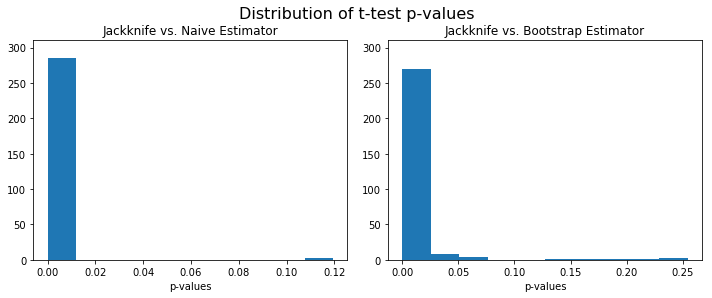

In [31]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
fig.suptitle('Distribution of t-test p-values',fontsize=16,y=1.025)

ax1.hist(naive_p_val, bins=10)
ax1.set_xlabel('p-values')
ax1.set_title('Jackknife vs. Naive Estimator')
ax2.hist(bootstrap_p_val, bins=10)
ax2.set_xlabel('p-values')
ax2.set_title('Jackknife vs. Bootstrap Estimator')

ax_ylims=[]
ax_ylims.append(ax1.get_ylim())
ax_ylims.append(ax2.get_ylim())
max_y_lim = np.max(ax_ylims)

ax1.set_ylim(0, max_y_lim + 10)
ax2.set_ylim(0, max_y_lim + 10)

plt.tight_layout()
plt.show()

### Plot top 5 most and least significant combinations

In [13]:
def add_value_labels(ax, spacing=5):
    """Add labels to the end of each bar in a bar chart.

    Arguments:
        ax (matplotlib.axes.Axes): The matplotlib object containing the axes
            of the plot to annotate.
        spacing (int): The distance between the labels and the bars.
    """

    # For each bar: Place a label
    for rect in ax.patches:
        # Get X and Y placement of label from rect.
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2

        # Number of points between bar and label. Change to your liking.
        space = spacing
        # Vertical alignment for positive values
        va = 'bottom'

        # If value of bar is negative: Place label below bar
        if y_value < 0:
            # Invert space to place label below
            space *= -1
            # Vertically align label at top
            va = 'top'

        # Use Y value as label and format number with one decimal place
        label = "{:.3f}".format(y_value)

        # Create annotation
        ax.annotate(
            label,                      # Use `label` as label
            (x_value, y_value),         # Place label at end of the bar
            xytext=(0, space),          # Vertically shift label by `space`
            textcoords="offset points", # Interpret `xytext` as offset in points
            ha='center',                # Horizontally center label
            va=va)                      # Vertically align label differently for
                                        # positive and negative values.

In [14]:
def two_scales(ax1, data1, data2, config, top):
    ax2 = ax1.twinx()
    ax1.bar([i - 0.2 for i in range(top)],
            data1,
            tick_label=config,
            color='red',
            width=0.3,
            label='t-test statistics')

    ax1.set_ylabel('t-test statistics')
    ax1_upper_y = data1.max() + 50
    ax1.set_ylim(0, ax1_upper_y)

    ax2.bar([i + 0.2 for i in range(top)],
            data2,
            color='blue',
            width=0.3,
            label='p-value')
    ax2.set_ylabel('p-value')
    ax2.set_ylim(0, 0.5)

    ax1.tick_params(axis='x', rotation=90)
    add_value_labels(ax1)
    add_value_labels(ax2)
    ax1.legend()
    ax2.legend(loc='upper right', bbox_to_anchor=(1, 0.9))
    return ax1, ax2

##


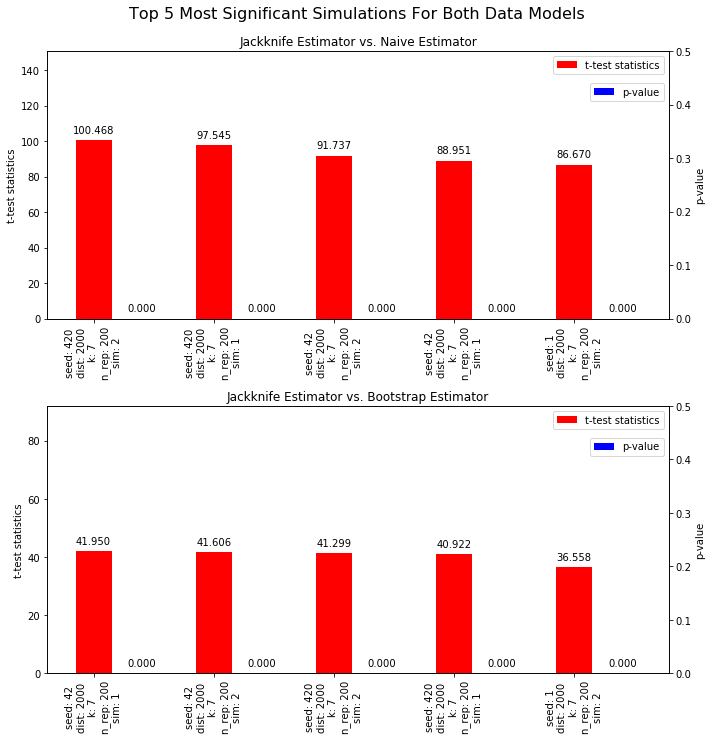

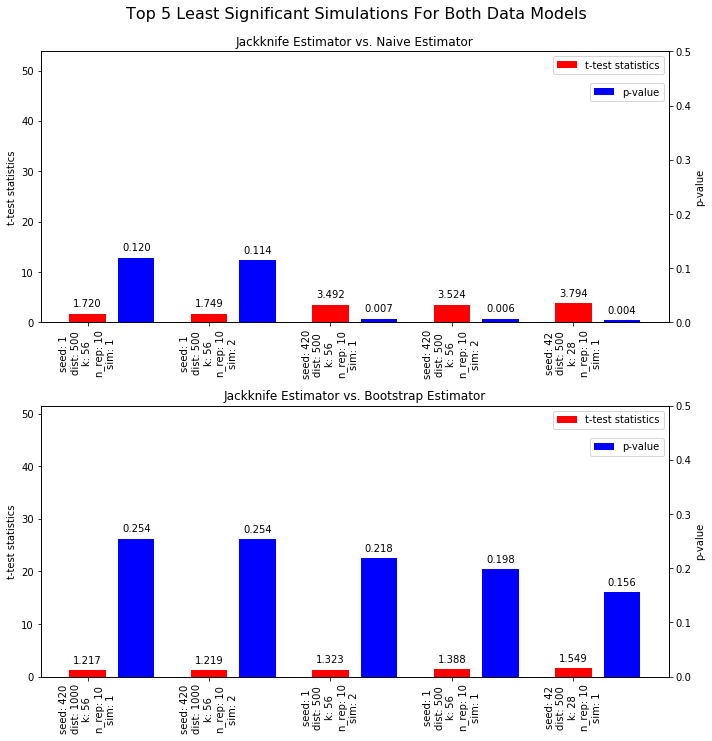

In [30]:
def plot_t_test(df, sim=None, mode='most', top=5):
    if sim:
        title = 'Top {} {} significant simulations with simulation {} data'.format(
            top, mode, sim).title()
        sel = df[df['sim'] == sim]
    else:
        title = 'Top {} {} significant simulations for both data models'.format(
            top, mode).title()
        sel = df
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))
    fig.suptitle(title, fontsize=16, y=1.025)

    sel['config'] = 'seed: ' + sel['seed'].astype(str) + '\ndist: ' + sel[
        'dist_size'].astype(str) + '\nk: ' + sel['k'].astype(
            str) + '\nn_rep: ' + sel['n_rep'].astype(
                str) + '\nsim: ' + sel['sim'].astype(str)

    if mode == 'most':
        sel = sel.sort_values(by=['naive_t_test_stat'], ascending=False)
    elif mode == 'least':
        sel = sel.sort_values(by=['naive_t_test_stat'], ascending=True)
    top_naive = sel.head(top)
    
    
    if mode == 'most':
        sel = sel.sort_values(by=['bootstrap_t_test_stat'], ascending=False)
    elif mode == 'least':
        sel = sel.sort_values(by=['bootstrap_t_test_stat'], ascending=True)
    top_bootstrap = sel.head(top)
    
    ax1, ax1a = two_scales(ax1, top_naive['naive_t_test_stat'],
                           top_naive['naive_t_test_p_val'],
                           top_naive['config'], top)
    ax1.set_title('Jackknife Estimator vs. Naive Estimator')

    ax2, ax2a = two_scales(ax2, top_bootstrap['bootstrap_t_test_stat'],
                           top_bootstrap['bootstrap_t_test_p_val'],
                           top_bootstrap['config'], top)

    ax2.set_title('Jackknife Estimator vs. Bootstrap Estimator')
    plt.tight_layout()
    plt.show()


plot_t_test(combination_results, mode='most')
plot_t_test(combination_results, mode='least')


In [16]:
naive_not_sig = combination_results[(combination_results['naive_t_test_p_val'] > 0.05)]
bootstrap_not_sig = combination_results[(combination_results['bootstrap_t_test_p_val'] > 0.05)]

In [17]:
naive_not_sig[[
    'sim', 'seed', 'dist_size', 'k', 'n_rep', 'naive_t_test_stat',
    'bootstrap_t_test_stat', 'naive_t_test_p_val', 'bootstrap_t_test_p_val'
]].describe()

,sim,seed,dist_size,k,n_rep,naive_t_test_stat,bootstrap_t_test_stat,naive_t_test_p_val,bootstrap_t_test_p_val
count,2.000000,2.0,2.0,2.0,2.0,2.000000,2.000000,2.000000,2.000000
mean,1.500000,1.0,500.0,56.0,10.0,1.734697,1.355940,0.116848,0.208362
std,0.707107,0.0,0.0,0.0,0.0,0.020450,0.045893,0.003752,0.014063
min,1.000000,1.0,500.0,56.0,10.0,1.720237,1.323488,0.114195,0.198418
25%,1.250000,1.0,500.0,56.0,10.0,1.727467,1.339714,0.115522,0.203390
50%,1.500000,1.0,500.0,56.0,10.0,1.734697,1.355940,0.116848,0.208362
75%,1.750000,1.0,500.0,56.0,10.0,1.741927,1.372165,0.118175,0.213334
max,2.000000,1.0,500.0,56.0,10.0,1.749157,1.388391,0.119501,0.218306


In [18]:
bootstrap_not_sig[[
    'sim', 'seed', 'dist_size', 'k', 'n_rep', 'naive_t_test_stat',
    'bootstrap_t_test_stat', 'naive_t_test_p_val', 'bootstrap_t_test_p_val'
]].describe()

,sim,seed,dist_size,k,n_rep,naive_t_test_stat,bootstrap_t_test_stat,naive_t_test_p_val,bootstrap_t_test_p_val
count,11.000000,11.000000,11.000000,11.000000,11.0,11.000000,11.000000,11.000000,11.000000
mean,1.454545,168.272727,590.909091,48.363636,10.0,3.500081,1.731449,0.024481,0.138557
std,0.522233,200.296326,202.259959,13.078782,0.0,0.903540,0.416432,0.045707,0.082076
min,1.000000,1.000000,500.000000,28.000000,10.0,1.720237,1.217293,0.002195,0.050730
25%,1.000000,21.500000,500.000000,42.000000,10.0,3.507777,1.355940,0.003079,0.062884
50%,1.000000,42.000000,500.000000,56.000000,10.0,3.850860,1.621697,0.003901,0.139318
75%,2.000000,420.000000,500.000000,56.000000,10.0,4.006799,2.122229,0.006644,0.208362
max,2.000000,420.000000,1000.000000,56.000000,10.0,4.233604,2.253284,0.119501,0.254447


### Correlation Analysis

In [19]:
corr_mat = combination_results[['sim', 'seed', 'dist_size', 'k','n_rep', 'naive_t_test_stat', 'bootstrap_t_test_stat', 'naive_t_test_p_val', 'bootstrap_t_test_p_val']].corr()
corr_mat.style.background_gradient(cmap='coolwarm')

,sim,seed,dist_size,k,n_rep,naive_t_test_stat,bootstrap_t_test_stat,naive_t_test_p_val,bootstrap_t_test_p_val
sim,1,0,-1.266e-18,0,0,0.0144717,0.00720596,-0.00239197,-0.00193845
seed,0,1,-3.55718e-16,-3.92585e-17,0,0.0329189,-0.00974468,-0.0640815,0.0368953
dist_size,-1.266e-18,-3.55718e-16,1,-5.39682e-17,0,0.399407,0.366891,-0.103422,-0.154634
k,0,-3.92585e-17,-5.39682e-17,1,0,-0.516685,-0.50118,0.148485,0.246991
n_rep,0,0,0,0,1,0.581385,0.661301,-0.111972,-0.246514
naive_t_test_stat,0.0144717,0.0329189,0.399407,-0.516685,0.581385,1,0.969121,-0.123271,-0.251127
bootstrap_t_test_stat,0.00720596,-0.00974468,0.366891,-0.50118,0.661301,0.969121,1,-0.135274,-0.290638
naive_t_test_p_val,-0.00239197,-0.0640815,-0.103422,0.148485,-0.111972,-0.123271,-0.135274,1,0.582704
bootstrap_t_test_p_val,-0.00193845,0.0368953,-0.154634,0.246991,-0.246514,-0.251127,-0.290638,0.582704,1
